# Stock Price Prediction Pipeline (with Sentiment & Macro)
End-to-end workflow demonstrating:
- Data loading
- Sentiment and macro feature engineering
- Exploratory visualizations
- Modeling and evaluation
- Simulated backtest and conclusions


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,6)
DATA_DIR = "../data/"


In [2]:
df = pd.read_csv(DATA_DIR + "features.csv", parse_dates=['date'])
print(df.head())
print(df.dtypes)


        date ticker  close_price  sentiment_score  usd_inr_rate  \
0 2019-01-01    TCS    1717.5715           0.0000         70.76   
1 2019-01-02    TCS    1736.0759           0.3818         70.76   
2 2019-01-03    TCS    1714.9988          -0.6486         70.76   
3 2019-01-03    TCS    1714.9988           0.0000         70.76   
4 2019-01-03    TCS    1714.9988          -0.3400         70.76   

   interest_rate  unemployment_rate  return_1  return_direction  
0           6.25                NaN       NaN                 1  
1           6.25                NaN  0.010774                 0  
2           6.25                NaN -0.012141                 0  
3           6.25                NaN  0.000000                 0  
4           6.25                NaN  0.000000                 0  
date                 datetime64[ns]
ticker                       object
close_price                 float64
sentiment_score             float64
usd_inr_rate                float64
interest_rate        

Missing values:
 date                     0
ticker                   0
close_price              0
sentiment_score          0
usd_inr_rate             0
interest_rate            0
unemployment_rate    17076
return_1                 6
return_direction         0
dtype: int64


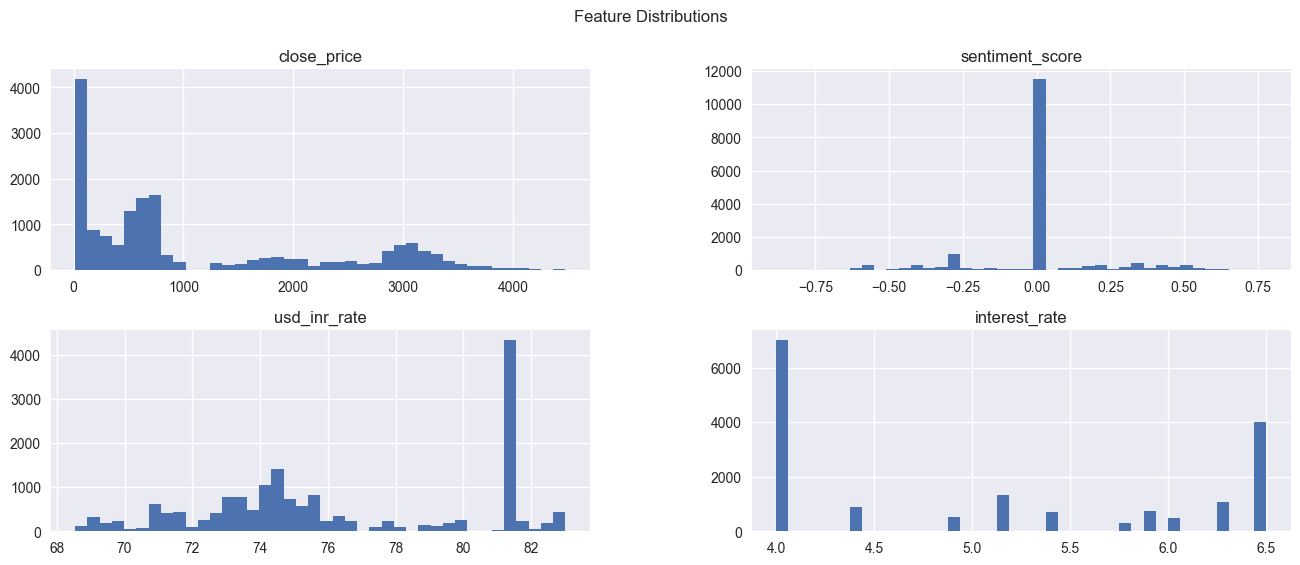

In [3]:
print("Missing values:\n", df.isna().sum())
df[['close_price', 'sentiment_score', 'usd_inr_rate', 'interest_rate']].hist(bins=40, figsize=(16,6))
plt.suptitle('Feature Distributions')
plt.show()


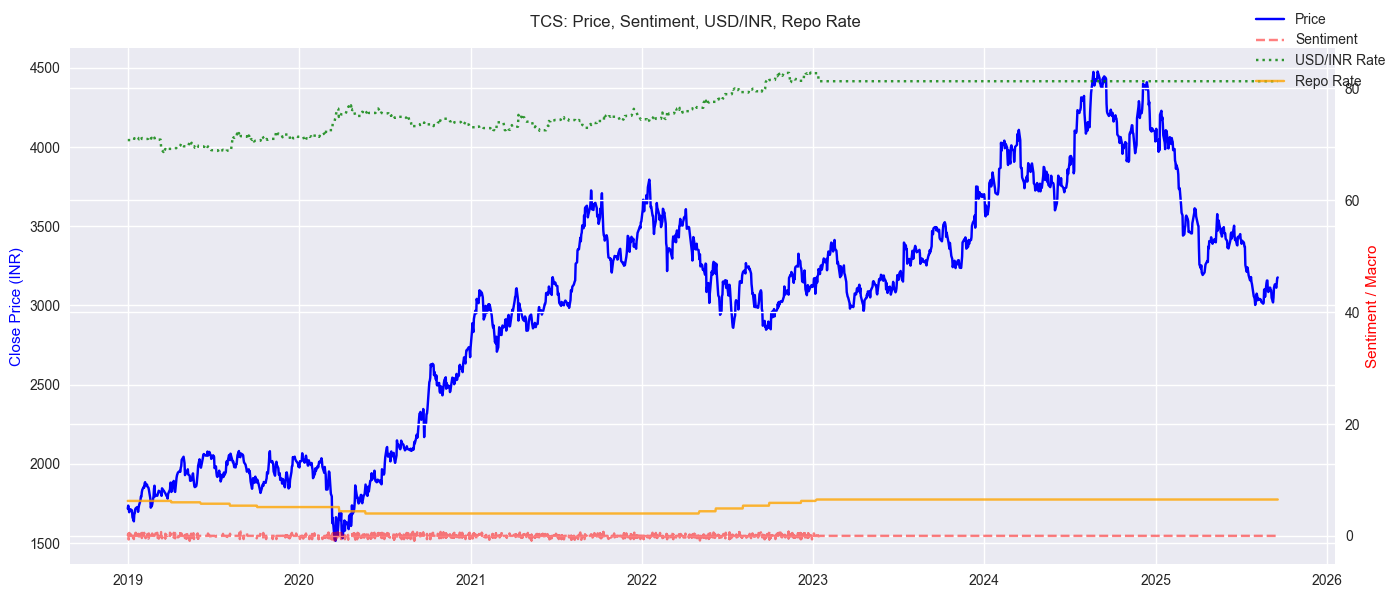

In [5]:
ticker = "TCS" # Change as needed
sub = df[df['ticker'] == ticker].sort_values('date')

fig, ax1 = plt.subplots()
ax1.plot(sub['date'], sub['close_price'], label='Price', color='b')
ax1.set_ylabel("Close Price (INR)", color='b')
ax2 = ax1.twinx()
ax2.plot(sub['date'], sub['sentiment_score'], 'r--', label='Sentiment', alpha=0.5)
ax2.plot(sub['date'], sub['usd_inr_rate'], 'g:', label='USD/INR Rate', alpha=0.8)
ax2.plot(sub['date'], sub['interest_rate'], 'orange', label='Repo Rate', alpha=0.8)
ax2.set_ylabel("Sentiment / Macro", color='r')
fig.suptitle(f"{ticker}: Price, Sentiment, USD/INR, Repo Rate")
fig.tight_layout()
fig.legend(loc="upper right")
plt.show()


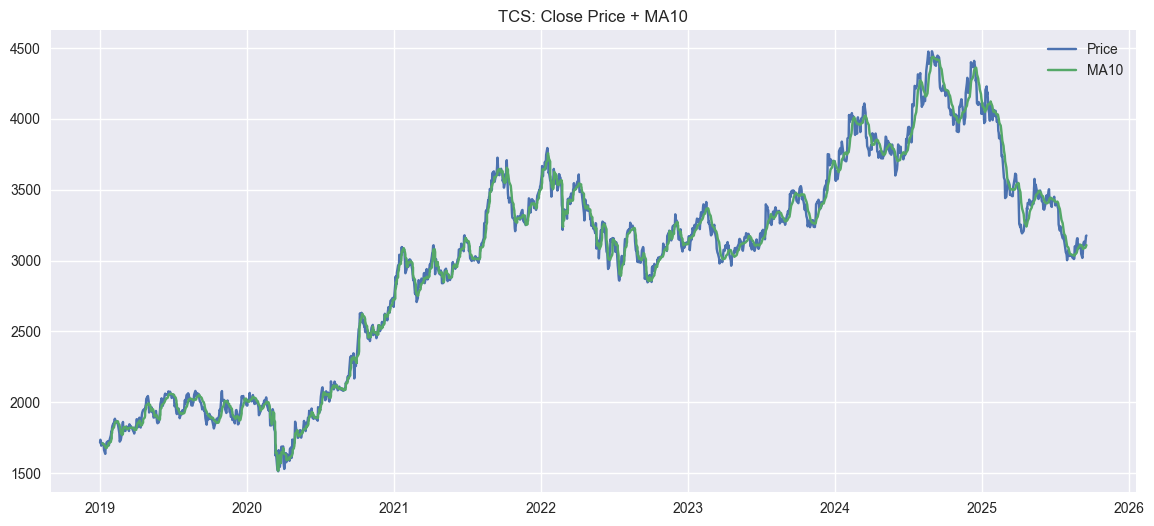

In [6]:
window = 10
sub['MA10'] = sub['close_price'].rolling(window).mean()
sub['RSI'] = sub['close_price'].pct_change().rolling(window).apply(lambda x: (np.where(x > 0, x, 0).sum() / np.abs(x).sum()) * 100 if np.abs(x).sum() > 0 else np.nan)

plt.plot(sub['date'], sub['close_price'], label='Price')
plt.plot(sub['date'], sub['MA10'], label='MA10')
plt.legend(); plt.title(f'{ticker}: Close Price + MA10')
plt.show()


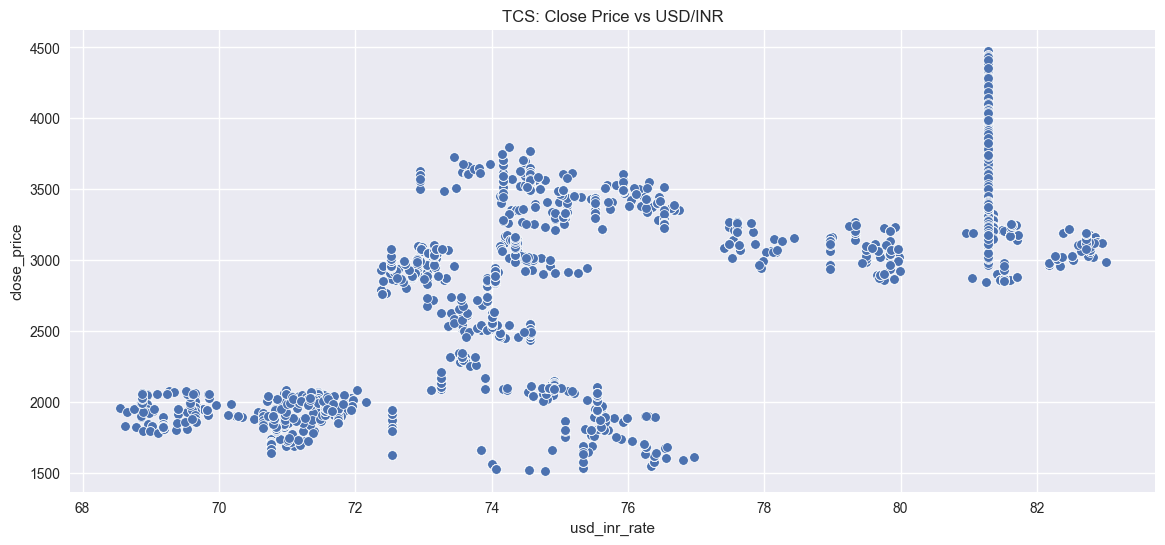

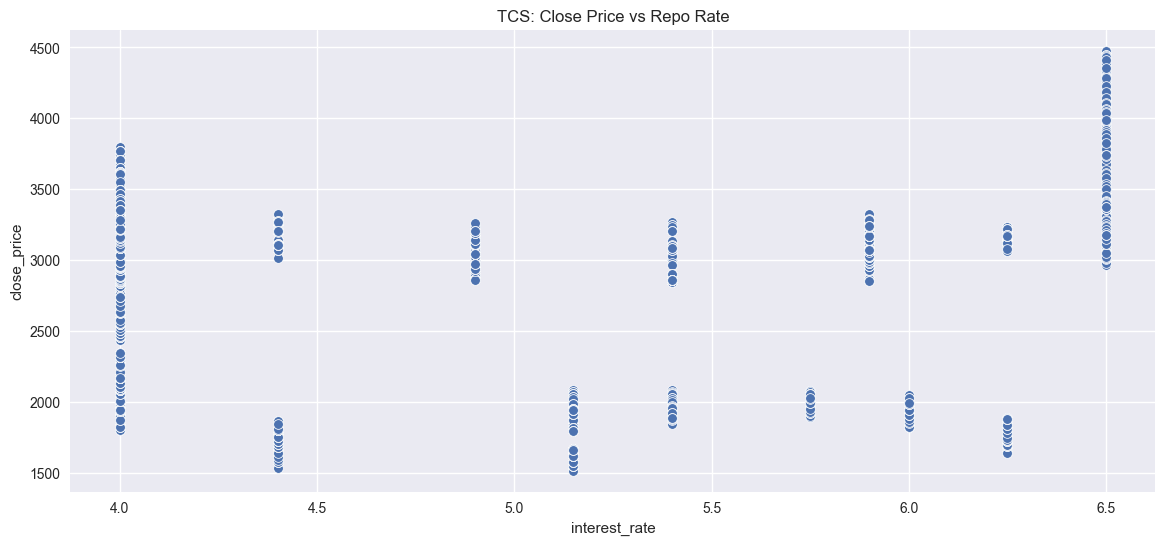

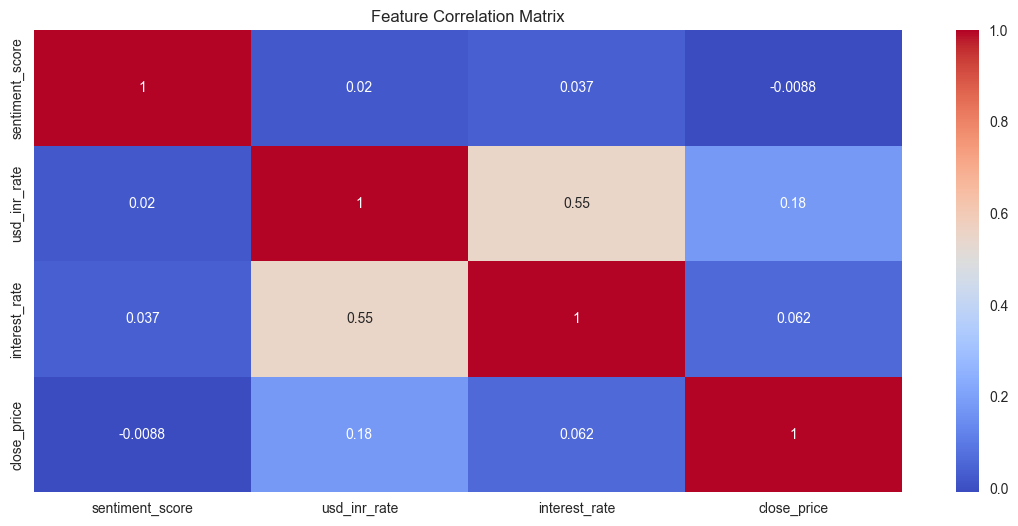

In [7]:
sns.scatterplot(data=sub, x='usd_inr_rate', y='close_price')
plt.title(f'{ticker}: Close Price vs USD/INR')
plt.show()

sns.scatterplot(data=sub, x='interest_rate', y='close_price')
plt.title(f'{ticker}: Close Price vs Repo Rate')
plt.show()

sns.heatmap(df[['sentiment_score', 'usd_inr_rate', 'interest_rate', 'close_price']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

features = ['close_price', 'sentiment_score', 'usd_inr_rate', 'interest_rate']
X = df[features]
y = df['return_direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Accuracy: 0.6279523716572321
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      3611
           1       0.41      0.59      0.48      1512

    accuracy                           0.63      5123
   macro avg       0.60      0.62      0.60      5123
weighted avg       0.68      0.63      0.64      5123



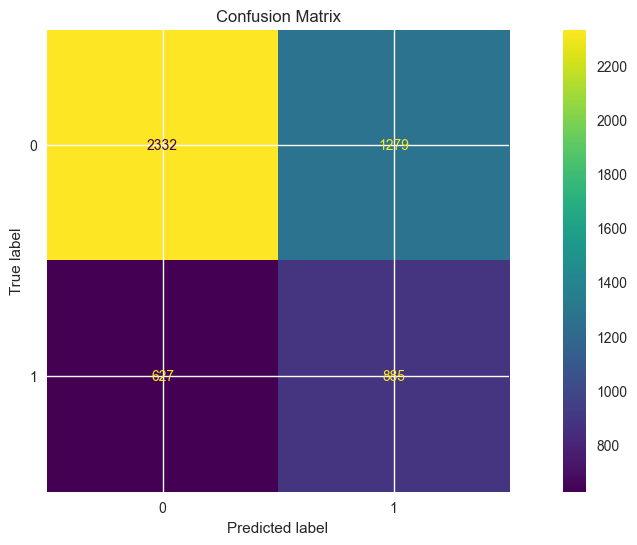

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred); plt.title("Confusion Matrix"); plt.show()


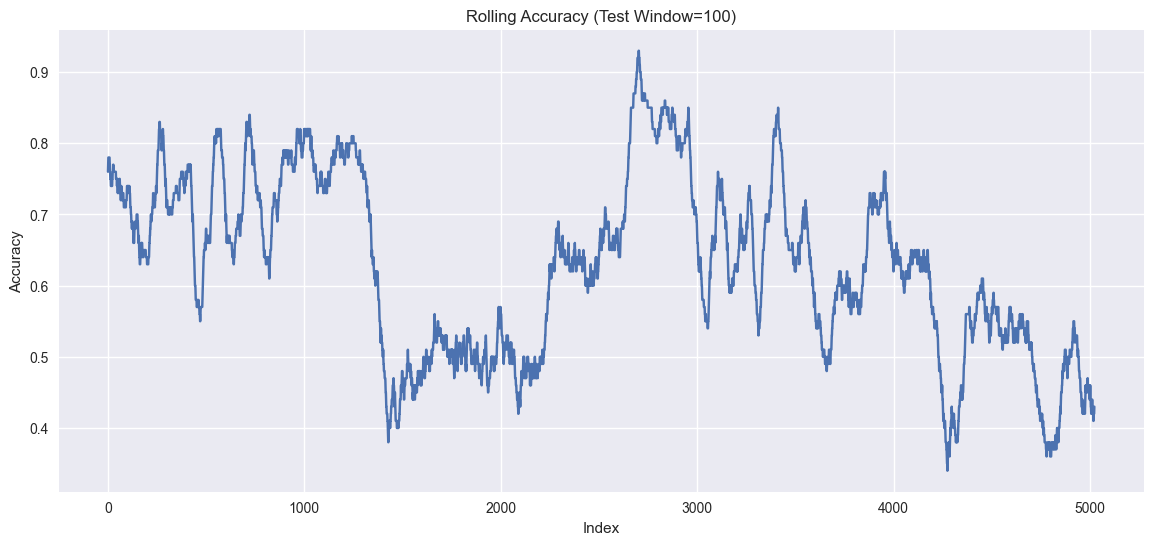

In [10]:
window_size = 100
rolling_acc = pd.Series([accuracy_score(y_test.iloc[i:i+window_size], y_pred[i:i+window_size]) for i in range(len(y_test)-window_size)])
plt.plot(rolling_acc)
plt.title('Rolling Accuracy (Test Window=100)')
plt.xlabel('Index'); plt.ylabel('Accuracy')
plt.show()


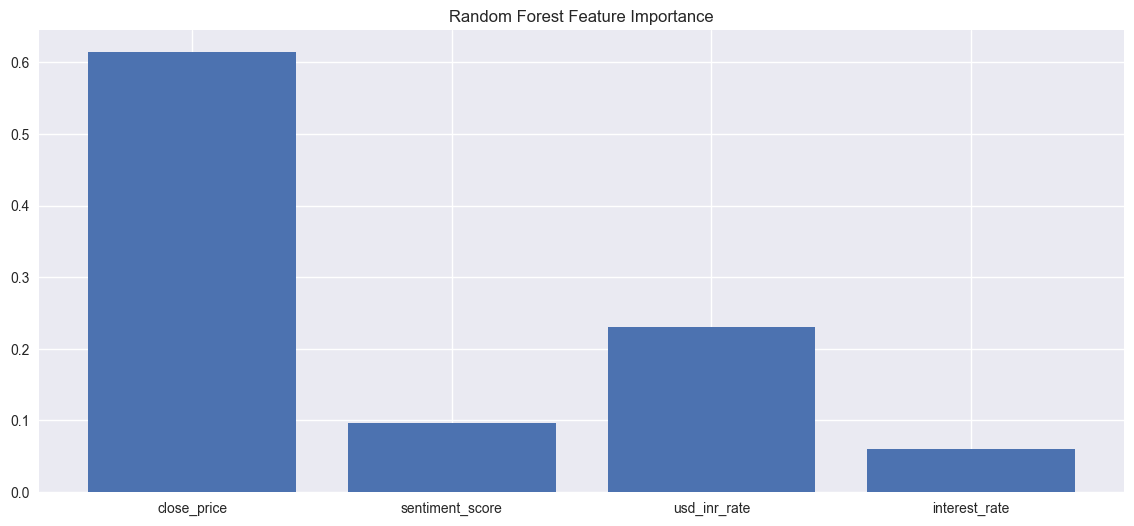

In [11]:
importances = rf.feature_importances_
plt.bar(features, importances)
plt.title('Random Forest Feature Importance')
plt.show()


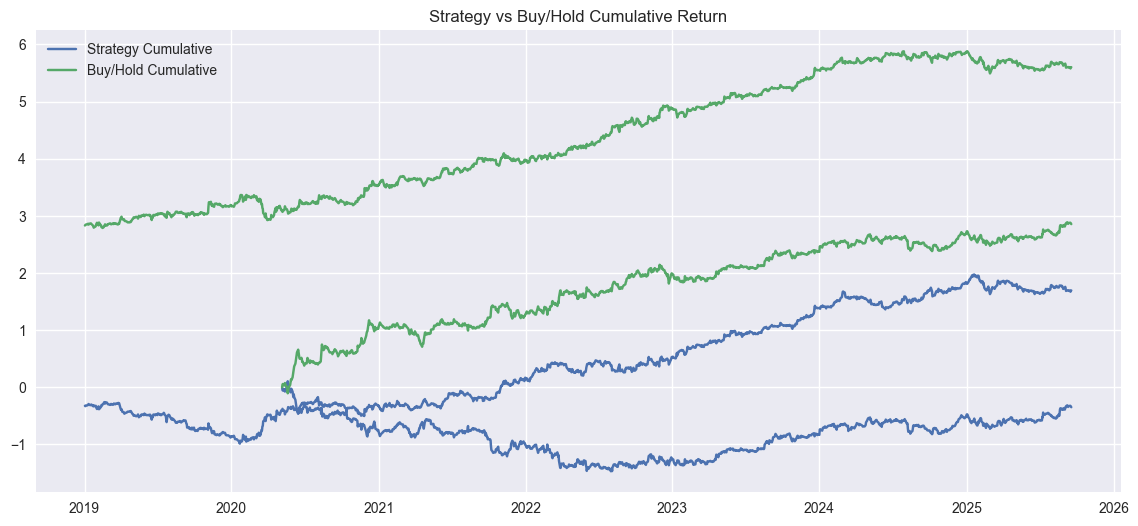

In [12]:
test_df = df.iloc[y_test.index].copy()
test_df['pred_signal'] = y_pred
test_df['strategy_return'] = test_df['return_1'] * test_df['pred_signal'].map({1: 1, 0: -1})
plt.plot(test_df['date'], test_df['strategy_return'].cumsum(), label='Strategy Cumulative')
plt.plot(test_df['date'], test_df['return_1'].cumsum(), label='Buy/Hold Cumulative')
plt.legend(); plt.title('Strategy vs Buy/Hold Cumulative Return')
plt.show()


In [13]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, None]}
search = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=3, scoring='accuracy', verbose=2)
search.fit(X_train, y_train)
print(search.best_params_)
print("Best CV accuracy:", search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ......................max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=5, n_e

## Conclusion & Next Steps

- Model predicts price return direction using sentiment & macro; accuracy and feature ranking shown.
- Simulated backtest demonstrates practical strategy vs. buy-and-hold.
- Further improvements: Add technical indicators, try time-series models, refine ticker-level sentiment, optimize hyperparameters.
